<a href="https://colab.research.google.com/github/javajaewook/Jaewook-Lee/blob/master/2020_1_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')
link = '/content/gdrive/My Drive/Colab Notebooks/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from google.colab import output as sound

def beepsound():
  sound.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.tensor
import matplotlib.pyplot as plt

from torch.optim import lr_scheduler

# hyper parameters
batch_size = 256
learning_rate = 0.01
num_epoch = 200
p_dropout = 0.5

In [0]:

cifar_train = dset.CIFAR10(link+"CIFAR10/", train = True, 
                           transform=transforms.Compose([
                                                         transforms.RandomHorizontalFlip(), 
                                                         transforms.RandomRotation(10),
                                                         transforms.ToTensor(),
                                                         transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),                    
]))
"""
# === (3) data normalization ===
cifar_train = dset.CIFAR10(link+"CIFAR10/", train = True, 
                           transform=transforms.Compose([
                                                         transforms.ToTensor(),
                                                         transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
                                                         ]), 
                                                         target_transform=None, download=False)
"""
cifar_test = dset.CIFAR10(link+"CIFAR10/", train = False, transform=transforms.Compose([
                                                         transforms.ToTensor(),
                                                         transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
                                                         ]), target_transform=None, download=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


length of cifar_train:  50000
length of cifar_test:  10000
shape of image data:  torch.Size([3, 32, 32])
label:  9


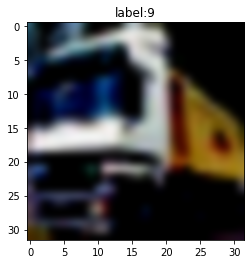

In [5]:
print("length of cifar_train: ", len(cifar_train))
print("length of cifar_test: ", len(cifar_test))

image, label = cifar_train.__getitem__(1)
print("shape of image data: ", image.size())
print("label: ", label)

img = image.numpy()

r,g,b = img[0,:,:], img[1,:,:], img[2,:,:]
img2 = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img2[:,:,0], img2[:,:,1], img2[:,:,2] = r,g,b

plt.title("label:%d" %label)
plt.imshow(img2, interpolation='bicubic')
plt.show()

정확도 검사용 함수 정의


In [0]:
def ComputeAccr(dloader, imodel):
  correct = 0
  total = 0
  for j, [imgs, labels] in enumerate(dloader):
    img =  torch.Tensor(imgs).requires_grad_(True).cuda()
    #img = torch.Tensor.requires_grad_(imgs),cuda()
    #img = Variable(imgs, volatile=True).cuda()
    label = torch.Tensor.detach_(labels).cuda()
    #label = Variable(labels).cuda()

    output = imodel.forward(img)
    _, output_index = torch.max(output, 1)

    total += label.size(0)
    correct += (output_index == label).sum().float()
  print("Accuracy of Test Data: {}" .format(100*correct/total))
  return (100*correct/total)

데이터를 로드하고, 모델을 선언



In [0]:
# === data load function ===
train_loader=torch.utils.data.DataLoader(list(cifar_train)[:], batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
test_loader=torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)

In [0]:
# === declare CNN model ===
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(3,16,3,padding=1),
        nn.ELU(),  # ELU
        #nn.Dropout2d(p_dropout),
        nn.BatchNorm2d(16),
        nn.Conv2d(16,32,3,padding=1),
        nn.ELU(),
        #nn.Dropout2d(p_dropout),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2,2),
        nn.Conv2d(32,64,3,padding=1),
        nn.ELU(),
        #nn.Dropout2d(p_dropout),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2)
    )
    self.fc_layer = nn.Sequential(
        nn.Linear(64*8*8, 100),
        nn.ELU(),
        #nn.Dropout2d(p_dropout),
        nn.BatchNorm1d(100),
        nn.Linear(100,10)
    )
    # weight Initializaztion (He)
    for m in self.modules():
      if (isinstance(m,nn.Conv2d)):
        init.kaiming_normal_(m.weight.data)
        m.bias.data.fill_(0)
      if (isinstance(m,nn.Linear)):
        init.kaiming_normal_(m.weight.data)
        m.bias.data.fill_(0)
  def forward(self,x):
    out=self.layer(x)
    out=out.view(batch_size, -1)
    out=self.fc_layer(out)

    return out

In [0]:
model=CNN().cuda()

In [0]:
# === loss, optimizer ===
loss_func = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(),lr=learning_rate) # (5) Adam optimizer

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, verbose=True, patience=10, min_lr=0) # ReduceLRonPlateau

In [0]:
model.train()
# === training ===
for i in range(num_epoch):
  for j, [image, label] in enumerate(train_loader):
    x= torch.Tensor(image).requires_grad_(True).cuda()
    y_= torch.Tensor.detach_(label).cuda()

    optimizer.zero_grad()
    output=model.forward(x)
    loss=loss_func(output, y_)
    loss.backward()
    optimizer.step()

  print("epoch: {}".format(i))
  model.eval()
  ComputeAccr(train_loader, model)
  ComputeAccr(test_loader, model)
  model.train()

epoch: 0
Accuracy of Test Data: 66.34214782714844
Accuracy of Test Data: 65.05408477783203
epoch: 1
Accuracy of Test Data: 71.31410217285156
Accuracy of Test Data: 69.6915054321289
epoch: 2
Accuracy of Test Data: 78.12700653076172
Accuracy of Test Data: 72.6863021850586
epoch: 3
Accuracy of Test Data: 83.33534240722656
Accuracy of Test Data: 73.09695434570312
epoch: 4
Accuracy of Test Data: 87.32972717285156
Accuracy of Test Data: 73.57772827148438
epoch: 5
Accuracy of Test Data: 88.60977935791016
Accuracy of Test Data: 72.77644348144531
epoch: 6
Accuracy of Test Data: 92.00521087646484
Accuracy of Test Data: 73.05689239501953
epoch: 7
Accuracy of Test Data: 94.27284240722656
Accuracy of Test Data: 72.67628479003906
epoch: 8
Accuracy of Test Data: 95.23237609863281
Accuracy of Test Data: 72.44591522216797
epoch: 9
Accuracy of Test Data: 96.42227935791016
Accuracy of Test Data: 72.54607391357422
epoch: 10
Accuracy of Test Data: 96.4783706665039
Accuracy of Test Data: 72.2956771850586
ep

In [0]:
model.eval()
ComputeAccr(test_loader, model)
beepsound()